## **installing libraries**

In [1]:
!pip install yfinance
!pip install darts
# !pip uninstall matplotlib
# !pip install matplotlib==3.1.3

## **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from darts.models import (
    LinearRegressionModel,
    ExponentialSmoothing,
    ARIMA, 
    RandomForest,
    Theta, 
    RegressionEnsembleModel, 
    NBEATSModel
)
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, mse
# Feature Scaling
from sklearn.preprocessing import StandardScaler

[2022-02-11 09:04:24,079] WARNING | darts.models | Support for AutoARIMA is not available.To enable it, install u8darts[pmdarima] or u8darts[all].
[2022-02-11 09:04:24,084] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).


## **Loading the Data**

In [36]:
# Download additional stock data, which is correlated to Tesla stock, after research we found that NASDAQ is very correlated

tesla_df = yf.download(['TSLA'], 
                      start='2013-01-02', 
                      end='2022-02-10', 
                      progress=False).reset_index()
nasdq_df = yf.download(['^IXIC'], 
                      start='2013-01-02', 
                      end='2022-02-10', 
                      progress=False).reset_index()

# Events is a self made data for the major events and its effect on tesla stock over the years
events = pd.read_excel('tesla_tweed_pre.xlsx', sheet_name='tesla_tweets')[['Date', 'accum_value']]
events = events[events['accum_value']!=0]
nasdq_df.columns = ['Date', 'NSDQ-Open', 'NSDQ-High', 'NSDQ-Low', 'NSDQ-Close', 'NSDQ-Adj Close', 'NSDQ-Volume']
tesla_df.columns = ['Date', 'tesla-Open', 'tesla-High', 'tesla-Low', 'tesla-Close', 'tesla-Adj Close', 'tesla-Volume']
event_tesla_merge = pd.merge(tesla_df, events, how='left', on='Date')
data = pd.merge(event_tesla_merge, nasdq_df, how='left', on='Date')
data['accum_value']=data['accum_value'].fillna(0)

# Data transformation
def date_extraction(dataset):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    # dataset['Year'] = pd.DatetimeIndex(dataset['Date']).year
    # dataset['Month'] = pd.DatetimeIndex(dataset['Date']).month
    # dataset['Day'] = dataset.Date.dt.day
    # dataset['DayOfWeek'] = dataset.Date.dt.dayofweek
    # dataset['WeekOfYear'] = dataset.Date.dt.weekofyear
    
    # dataset['Series'] = np.arange(1,len(data)+1)
date_extraction(data)
data.tail(2)

,Date,tesla-Open,tesla-High,tesla-Low,tesla-Close,tesla-Adj Close,tesla-Volume,accum_value,NSDQ-Open,NSDQ-High,NSDQ-Low,NSDQ-Close,NSDQ-Adj Close,NSDQ-Volume
2292,2022-02-08,905.530029,926.289978,894.799988,922.0,922.0,16909700,224.49,13984.429688,14226.480469,13934.780273,14194.450195,14194.450195,4277150000
2293,2022-02-09,935.000000,946.270020,920.000000,932.0,932.0,17419800,224.49,14368.160156,14490.719727,14330.870117,14490.370117,14490.370117,4713210000


In [37]:
data = data.filter(['Date', 'tesla-Close', 'accum_value', 'tesla-High', 'tesla-Low', 'NSDQ-Close',  'NSDQ-Volume'], axis=1)
data = data.iloc[1500:].reset_index(drop=True).fillna(method='bfill')
full_dates = pd.DataFrame(pd.date_range(start = '2018-12-17', end = '2022-02-10', freq = 'D'), columns=['Date'])
data_fill = pd.merge(full_dates, data, how='left', on='Date').fillna(method='ffill')
data_fill


,Date,tesla-Close,accum_value,tesla-High,tesla-Low,NSDQ-Close,NSDQ-Volume
0,2018-12-17,69.683998,100.11,73.139999,68.776001,6753.729980,2.665240e+09
1,2018-12-18,67.405998,100.11,70.309998,66.737999,6783.910156,2.595400e+09
2,2018-12-19,66.594002,100.11,69.402000,65.947998,6636.830078,2.899950e+09
3,2018-12-20,63.076000,100.11,66.057999,62.374001,6528.410156,3.258090e+09
4,2018-12-21,63.953999,100.11,64.694000,62.487999,6332.990234,4.534120e+09
...,...,...,...,...,...,...,...
1147,2022-02-06,923.320007,224.49,936.500000,881.169983,14098.009766,4.104120e+09
1148,2022-02-07,907.340027,224.49,947.770020,902.710022,14015.669922,4.253020e+09
1149,2022-02-08,922.000000,224.49,926.289978,894.799988,14194.450195,4.277150e+09
1150,2022-02-09,932.000000,224.49,946.270020,920.000000,14490.370117,4.713210e+09


## **Plotting, selecting, and describing data**

In [9]:
data_fill.corr()

,tesla-Close,accum_value,tesla-High,tesla-Low,NSDQ-Close,NSDQ-Volume
tesla-Close,1.000000,0.932402,0.999461,0.999366,0.963016,0.735747
accum_value,0.932402,1.000000,0.932220,0.933467,0.955805,0.779017
tesla-High,0.999461,0.932220,1.000000,0.999302,0.961607,0.739022
tesla-Low,0.999366,0.933467,0.999302,1.000000,0.964278,0.734633
NSDQ-Close,0.963016,0.955805,0.961607,0.964278,1.000000,0.695989
NSDQ-Volume,0.735747,0.779017,0.739022,0.734633,0.695989,1.000000


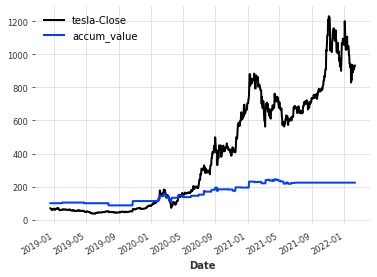

In [38]:
data_merged = TimeSeries.from_dataframe(data_fill, time_col = 'Date', value_cols = ['accum_value','tesla-Close'],
                                    fill_missing_dates=True, freq='d')
col = ['tesla-Close', 'accum_value']
data_merged[col].plot()

In [39]:
data_fill

,Date,tesla-Close,accum_value,tesla-High,tesla-Low,NSDQ-Close,NSDQ-Volume
0,2018-12-17,69.683998,100.11,73.139999,68.776001,6753.729980,2.665240e+09
1,2018-12-18,67.405998,100.11,70.309998,66.737999,6783.910156,2.595400e+09
2,2018-12-19,66.594002,100.11,69.402000,65.947998,6636.830078,2.899950e+09
3,2018-12-20,63.076000,100.11,66.057999,62.374001,6528.410156,3.258090e+09
4,2018-12-21,63.953999,100.11,64.694000,62.487999,6332.990234,4.534120e+09
...,...,...,...,...,...,...,...
1147,2022-02-06,923.320007,224.49,936.500000,881.169983,14098.009766,4.104120e+09
1148,2022-02-07,907.340027,224.49,947.770020,902.710022,14015.669922,4.253020e+09
1149,2022-02-08,922.000000,224.49,926.289978,894.799988,14194.450195,4.277150e+09
1150,2022-02-09,932.000000,224.49,946.270020,920.000000,14490.370117,4.713210e+09


## **Scalling and Training / Validation split**

In [40]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

# Changing our data to timeseries product for the darts library
data_ts = TimeSeries.from_dataframe(data_fill, 
                                    time_col = 'Date', 
                                    value_cols = 'tesla-Close',
                                    fill_missing_dates=True, freq='d')
covariates = TimeSeries.from_dataframe(data_fill, 
                                    time_col = 'Date', 
                                    value_cols = ['accum_value', 'tesla-High', 'tesla-Low', 'NSDQ-Close',  'NSDQ-Volume'],
                                    fill_missing_dates=True, freq='d')

scaler_target = Scaler()
data_ts_transformed = scaler_target.fit_transform(data_ts)
train_transformed, val_transformed = data_ts_transformed.split_before(pd.Timestamp('20210209'))

scaler_covariate = Scaler()
covariate_transformed = scaler_covariate.fit_transform(covariates)
past_cov, future_cov = covariate_transformed.split_before(pd.Timestamp('20210209')) 

# **Deep learning Models**

## **Temporal convolutional netword Models**

In [47]:
train_transformed.describe(), val_transformed.describe()

(component  tesla-Close
 count       785.000000
 mean          0.139204
 std           0.181265
 min           0.000000
 25%           0.014982
 50%           0.044569
 75%           0.220764
 max           0.709559,
 component  tesla-Close
 count       367.000000
 mean          0.637323
 std           0.145595
 min           0.441503
 25%           0.529686
 50%           0.583357
 75%           0.750518
 max           1.000000)

In [48]:
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood

deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=20,
    optimizer_kwargs={'lr': 1e-3},
    random_state=0,
    input_chunk_length=100,
    output_chunk_length=30,
    kernel_size=3,
    num_filters=4,
    likelihood=GaussianLikelihood())

deeptcn.fit(series=train_transformed, past_covariates=past_cov)



[2022-02-11 09:31:42,943] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 656 samples.
[2022-02-11 09:31:42,943] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 656 samples.
[2022-02-11 09:31:42,950] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-02-11 09:31:42,950] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-02-11 09:31:42,956] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-11 09:31:42,956] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


MAPE = 14.06%


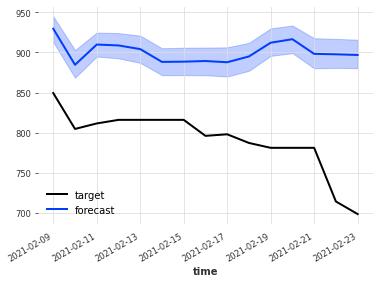

In [49]:
pred = deeptcn.predict(15, past_covariates=past_cov, num_samples=1000)
pred_orig = scaler_target.inverse_transform(pred)

val_orig = scaler_target.inverse_transform(val_transformed)
val_orig.slice_intersect(pred_orig).plot(label='target')

pred_orig.plot(label='forecast')
training = scaler_target.inverse_transform(train_transformed)
print('MAPE = {:.2f}%'.format(mape(val_orig, pred_orig)))

### **Metrics**

In [18]:
from darts.metrics import mape, mase, mae, rmse

mape_score = mape(val_orig, pred_orig)
mae_score = mae(val_orig, pred_orig)
rmse_score = rmse(val_orig, pred_orig)

print('TCN model MAPE is: {}%'.format(round(mape_score,2)))
print('TCN model MAE is: {}'.format(round(mae_score, 2)))
print('TCN model RMSE is: {}'.format(round(rmse_score)))


TCN model MAPE is: 10.46%
TCN model MAE is: 97.5
TCN model RMSE is: 98


In [ ]:
evaluation = pd.DataFrame({'TCN': [round((mape_score),2), round(mae_score, 2),round(rmse_score) ]}, index=['MAPE', 'MAE', 'RMSE'])
evaluation.to_csv('evaluation_TCN.csv')
evaluation

,TCN
MAPE,2.65
MAE,17.48
RMSE,21.00


## **NBEATS model**

In [ ]:
model = NBEATSModel(input_chunk_length=30, output_chunk_length=15, n_epochs=100, random_state=0)

model.fit(series=train_transformed, past_covariates=past_cov, verbose=True)



[2022-01-22 17:23:37,512] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 867 samples.
[2022-01-22 17:23:37,512] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 867 samples.
[2022-01-22 17:23:37,599] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-22 17:23:37,599] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  1%|          | 1/100 [00:02<04:11,  2.54s/it]

 11%|█         | 11/100 [00:26<03:31,  2.38s/it]

 21%|██        | 21/100 [00:50<03:07,  2.37s/it]

 31%|███       | 31/100 [01:13<02:43,  2.37s/it]

 41%|████      | 41/100 [01:37<02:19,  2.37s/it]

 51%|█████     | 51/100 [02:01<01:57,  2.39s/it]

 61%|██████    | 61/100 [02:25<01:33,  2.39s/it]

 71%|███████   | 71/100 [02:49<01:09,  2.39s/it]

 81%|████████  | 81/100 [03:13<00:45,  2.39s/it]

 91%|█████████ | 91/100 [03:36<00:21,  2.38s/it]

100%|██████████| 100/100 [03:58<00:00,  2.38s/it]


### **Plotting**

MAPE = 5.29%


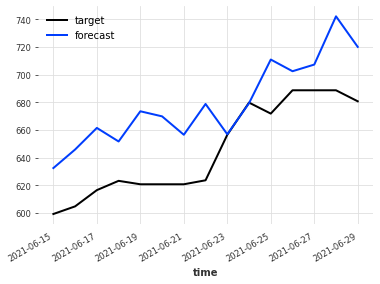

In [ ]:
# pred = model.predict(n=15, series=train_transformed, num_samples=10)
# pred_orig = scaler_target.inverse_transform(pred)
# val_orig = scaler_target.inverse_transform(val_transformed)

# val_orig.plot(label='actual')
# pred_orig.plot(label='forecast')

# plt.legend();

pred = model.predict(15, past_covariates=past_cov, num_samples=1)
pred_orig = scaler_target.inverse_transform(pred)
val_orig = scaler_target.inverse_transform(val_transformed)
val_orig.slice_intersect(pred_orig).plot(label='target')

pred_orig.plot(label='forecast')
training = scaler_target.inverse_transform(train_transformed)
print('MAPE = {:.2f}%'.format(mape(val_orig, pred_orig)))

### **Metrics**

In [ ]:
mape_score = mape(val_orig, pred_orig)
mae_score = mae(val_orig, pred_orig)
rmse_score = rmse(val_orig, pred_orig)

print('NBEATS model MAPE is: {}%'.format(round(mape_score, 2)))
print('NBEATS model MAE is: {}'.format(round(mae_score, 2)))
print('NBEATS model RMSE is: {}'.format(round(rmse_score)))

NBEATS model MAPE is: 5.29%
NBEATS model MAE is: 33.68
NBEATS model RMSE is: 38


In [ ]:
evaluation = pd.DataFrame({'NBEATS': [round((mape_score),2), round(mae_score, 2),round(rmse_score) ]}, index=['MAPE', 'MAE', 'RMSE'])
evaluation.to_csv('evaluation_NBEATS.csv')
evaluation

,NBEATS
MAPE,5.29
MAE,33.68
RMSE,38.00


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

In [52]:
# Read data:
ts = AirPassengersDataset().load()
scaler = Scaler()
ts = scaler.fit_transform(
    ts
)  # scale the whole time series not caring about train/val split...

# We'll use the month as a covariate
month_series = datetime_attribute_timeseries(ts, attribute="month", one_hot=True)
scaler_month = Scaler()
month_series = scaler_month.fit_transform(month_series)

# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp("19580801"))
train_month, val_month = month_series.split_after(pd.Timestamp("19580801"))

In [68]:
train_month.pd_dataframe()

component,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Month,,,,,,,,,,,,
1949-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1949-02-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1949-03-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1949-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1949-05-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1958-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1958-05-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1958-06-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
